# Processing and Plotting SeaBASS (.sb) Files

This notebook contains a workflow for reading multiple SeaBASS (`.sb`) files from a folder, combining them, subsetting the data by date and station, and then plotting specific parameters.

We will use:
* `SB_support.py` (the provided module) to read the files.
* `pandas` to aggregate and filter the data.
* `matplotlib` to plot the results.

# Workflow:

The notebook:
1.  Loads all `.sb` files from the target directory.
2.  Parses them using the `readSB` class.
3.  Combines them into a single `pandas.DataFrame`.
4.  Filteres the data based on your specified `station` and `datetime` range.
5.  Plots the requested parameters (`ag`, `ap`, `ad`) over time.

In [11]:
import os
import tarfile
import glob
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime
import re  # Import regular expressions
import folium
from folium.plugins import MarkerCluster

# Import the readSB class from the local .py file
try:
    from SB_support import readSB
    print("SB_support module loaded successfully.")
except ImportError:
    print("ERROR: Could not find SB_support.py.")
    print("Please make sure SB_support.py is in the same directory as this notebook.")

# Set up plotting style
plt.style.use('ggplot')
%matplotlib inline

SB_support module loaded successfully.


### Decompress Archive and List .sb Files

In [2]:
# --- Configuration ---
SOURCE_FOLDER = 'seabass_data'
DECOMPRESSED_FOLDER = 'seabass_data_decompressed'
# ---------------------

print(f"Searching for .tar archives in '{SOURCE_FOLDER}'...")

# Find any tar files (common extensions)
search_paths = [
    os.path.join(SOURCE_FOLDER, '*.tar'),
    os.path.join(SOURCE_FOLDER, '*.tar.gz'),
    os.path.join(SOURCE_FOLDER, '*.tgz')
]

tar_files_found = []
for path in search_paths:
    tar_files_found.extend(glob.glob(path))

if not tar_files_found:
    print(f"ERROR: No .tar, .tar.gz, or .tgz files found in '{SOURCE_FOLDER}'.")
else:
    # Use the first archive found
    tar_file_path = tar_files_found[0]
    print(f"Found archive: {tar_file_path}")

    # Create the output directory if it doesn't exist
    os.makedirs(DECOMPRESSED_FOLDER, exist_ok=True)
    
    extracted_filenames = []
    
    try:
        # Open the tar file with auto-compression detection ('r:*')
        with tarfile.open(tar_file_path, 'r:*') as tar:
            
            print(f"Extracting '.sb' files to '{DECOMPRESSED_FOLDER}'...")
            
            # Find and extract only members that are .sb files
            for member in tar.getmembers():
                if member.name.endswith('.sb') and member.isfile():
                    tar.extract(member, path=DECOMPRESSED_FOLDER)
                    # Store just the base name of the file
                    extracted_filenames.append(os.path.basename(member.name))
        
        if not extracted_filenames:
            print("No '.sb' files were found inside the archive.")
        else:
            print(f"\nSuccessfully extracted {len(extracted_filenames)} .sb files.")
            
            # --- Print the first 10 filenames ---
            print("\nFirst 10 extracted filenames:")
            for filename in extracted_filenames[:10]:
                print(f"  -> {filename}")

    except tarfile.ReadError:
        print(f"ERROR: File is not a valid tar archive: {tar_file_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Searching for .tar archives in 'seabass_data'...
Found archive: seabass_data/ws25130.tar
Extracting '.sb' files to 'seabass_data_decompressed'...


/tmp/ipykernel_2065657/575363068.py:40: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extract(member, path=DECOMPRESSED_FOLDER)



Successfully extracted 123 .sb files.

First 10 extracted filenames:
  -> SFMBON_WS25130_ap_4_2m_273_202505160818_R1.sb
  -> SFMBON_WS25130_ag_CAL6_2m_151_202505142040_R1.sb
  -> SFMBON_WS25130_ap_30_2m_065_202505150137_R1.sb
  -> SFMBON_WS25130_ap_54_2m_123_202505111505_R1.sb
  -> SFMBON_WS25130_ag_49_3m_138_202505111828_R1.sb
  -> SFMBON_WS25130_ap_57.2_2m_103_202505111118_R1.sb
  -> SFMBON_WS25130_ap_WS_14m_053_202505150907_R1.sb
  -> SFMBON_WS25130_ap_41_2m_143_202505112145_R1.sb
  -> SFMBON_WS25130_ap_12_2m_023_202505152342_R1.sb
  -> SFMBON_WS25130_ap_RP1_2m_165_202505121129_R1.sb


### Read the .sb file and Plot Spectral Data (Wavelength vs. Parameter)

Found 123 total .sb files. Filtering based on headers...

Found 61 files to plot. Reading and plotting...


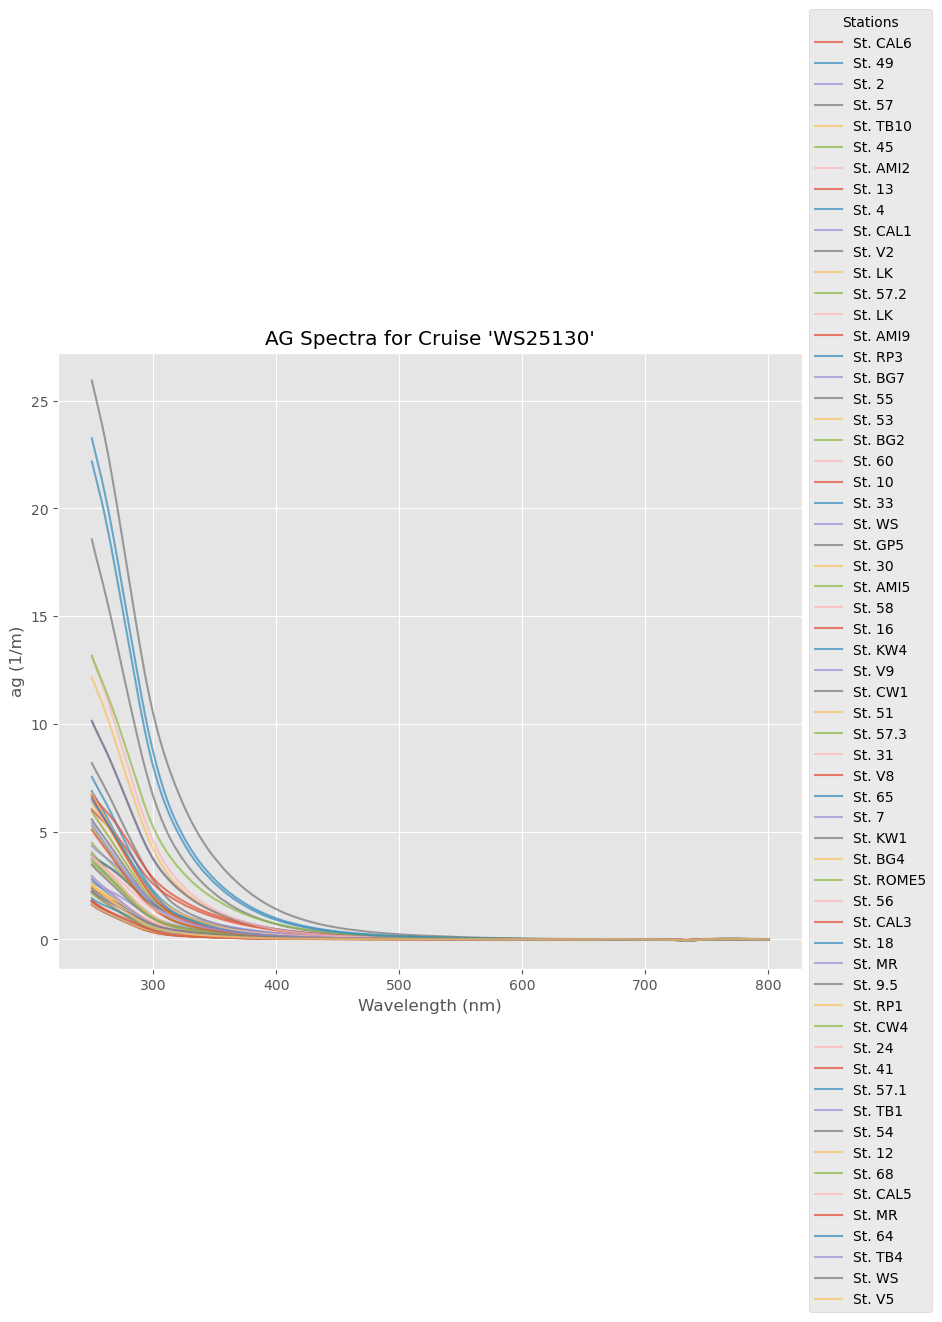

In [3]:
# --- Configuration ---
DECOMPRESSED_FOLDER = 'seabass_data_decompressed'
PARAMETER_TO_PLOT = 'ag'
TARGET_CRUISE = 'WS25130'
TARGET_STATION = 'ALL' # Set to 'ALL', None, or a specific station like 'WS'
# ---------------------

# --- 1. Find all .sb files ---
search_path = os.path.join(DECOMPRESSED_FOLDER, '**', '*.sb')
all_sb_files = glob.glob(search_path, recursive=True)

# --- List to hold data for the *next* cell ---
files_to_map = [] 
# ---------------------------------------------

files_to_process = []
station_labels = []

print(f"Found {len(all_sb_files)} total .sb files. Filtering based on headers...")

# --- 2. Filter files by reading metadata ---
for f_path in all_sb_files:
    try:
        sb_data = readSB(filename=f_path, no_warn=True)
        
        # --- Apply Filters ---
        if sb_data.headers.get('cruise') != TARGET_CRUISE:
            continue
            
        file_station = sb_data.headers.get('station', 'unknown')
        if TARGET_STATION is not None and TARGET_STATION.upper() != 'ALL':
            if file_station != TARGET_STATION:
                continue
                
        if 'wavelength' not in sb_data.data or PARAMETER_TO_PLOT not in sb_data.data:
            continue
            
        # --- If all checks pass, save file for plotting ---
        files_to_process.append(f_path)
        station_labels.append(file_station)
        
        # --- Extract and save coordinate data for mapping ---
        lat_str = sb_data.headers.get('north_latitude', None)
        lon_str = sb_data.headers.get('east_longitude', None)
        
        if lat_str and lon_str:
            try:
                lat = float(lat_str.replace('[DEG]', ''))
                lon = float(lon_str.replace('[DEG]', ''))
                # Add this file's info to our map list
                files_to_map.append({
                    'station': file_station,
                    'lat': lat,
                    'lon': lon,
                    'file': os.path.basename(f_path)
                })
            except (ValueError, TypeError):
                print(f"  -> Warning: Could not parse coordinates for {os.path.basename(f_path)}. Will not be mapped.")
        
    except Exception as e:
        print(f"  -> Warning: Skipped {os.path.basename(f_path)} due to read error: {e}")

# --- 3. Plot the filtered files ---
if not files_to_process:
    print(f"\nNo files matched your filter criteria. Nothing to plot.")
    # ... (rest of error printing) ...
else:
    print(f"\nFound {len(files_to_process)} files to plot. Reading and plotting...")
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for f_path, station_label in zip(files_to_process, station_labels):
        # ... (rest of plotting code is identical) ...
        try:
            sb_data = readSB(filename=f_path, no_warn=True)
            df = pd.DataFrame(sb_data.data)
            df['wavelength'] = pd.to_numeric(df['wavelength'], errors='coerce')
            df[PARAMETER_TO_PLOT] = pd.to_numeric(df[PARAMETER_TO_PLOT], errors='coerce')
            df_clean = df.dropna(subset=['wavelength', PARAMETER_TO_PLOT])
            df_sorted = df_clean.sort_values(by='wavelength')
            ax.plot(df_sorted['wavelength'], df_sorted[PARAMETER_TO_PLOT], 
                    label=f"St. {station_label}", 
                    alpha=0.7)
        except Exception as e:
            print(f"  -> ERROR plotting {os.path.basename(f_path)}: {e}")

    # --- 4. Finalize Plot ---
    plot_title = f"{PARAMETER_TO_PLOT.upper()} Spectra for Cruise '{TARGET_CRUISE}'"
    if TARGET_STATION is not None and TARGET_STATION.upper() != 'ALL':
        plot_title += f" (Station: {TARGET_STATION})"
    
    ax.set_title(plot_title)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel(f"{PARAMETER_TO_PLOT} (1/m)")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Stations")
    ax.grid(True)
    plt.show()

### Show the location of the sampling station

In [4]:
print("--- Generating Map ---")

# Check if the 'files_to_map' list was created by the previous cell
if 'files_to_map' not in locals() or not files_to_map:
    print("ERROR: 'files_to_map' list not found or is empty.")
    print("Please (re)run the previous cell (Cell 3) to filter and collect data first.")
else:
    print(f"Found {len(files_to_map)} stations to map.")
    
    # Calculate the center of the map
    lats = [item['lat'] for item in files_to_map]
    lons = [item['lon'] for item in files_to_map]
    avg_lat = sum(lats) / len(lats)
    avg_lon = sum(lons) / len(lons)

    # Create the map, centered on the average location
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)
    
    # Create a cluster group to hold the markers
    marker_cluster = MarkerCluster().add_to(m)

    # Add a marker for each file found
    for item in files_to_map:
        
        # Create popup message
        popup_html = f"""
        <b>Station:</b> {item['station']}<br>
        <b>File:</b> {item['file']}<br>
        <b>Coords:</b> {item['lat']}, {item['lon']}
        """

        # Add a marker to the *cluster*
        folium.Marker(
            [item['lat'], item['lon']],
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=f"Station {item['station']}"
        ).add_to(marker_cluster)

    # Display the map
    print("Displaying map with all filtered stations...")
    display(m)

--- Generating Map ---
Found 61 stations to map.
Displaying map with all filtered stations...


### Load SFER_data.csv and Create Final Table

In [12]:
# --- Configuration ---
# Folder with decompressed files (from Cell 2)
DECOMPRESSED_FOLDER = 'seabass_data_decompressed'
SFER_FILE = 'SFER_data.csv'

# 1. Parameter to filter by and extract
PARAMETER_TO_EXTRACT = 'ag'
TARGET_WAVELENGTH = 443

# 2. Cruise ID to filter by
TARGET_CRUISE = 'WS25130'

# 3. Station ID to filter by
#    Set to 'ALL' or None to get all stations from the cruise.
TARGET_STATION = 'ALL' 
# --- End Configuration ---

# --- 1. Find all .sb files ---
search_path = os.path.join(DECOMPRESSED_FOLDER, '**', '*.sb')
all_sb_files = glob.glob(search_path, recursive=True)

# This list will hold the extracted data from each file
extracted_data_list = []

print(f"Found {len(all_sb_files)} total .sb files. Filtering and extracting...")

# --- 2. Filter files and extract data ---
for f_path in all_sb_files:
    try:
        sb_data = readSB(filename=f_path, no_warn=True)
        
        # --- Apply Filters ---
        if sb_data.headers.get('cruise') != TARGET_CRUISE:
            continue
            
        file_station = sb_data.headers.get('station', 'unknown')
        if TARGET_STATION is not None and TARGET_STATION.upper() != 'ALL':
            if file_station != TARGET_STATION:
                continue
                
        if 'wavelength' not in sb_data.data or PARAMETER_TO_EXTRACT not in sb_data.data:
            continue
            
        # --- If all checks pass, extract the data ---
        
        # A) Extract metadata
        lat_str = sb_data.headers.get('north_latitude', None)
        lon_str = sb_data.headers.get('east_longitude', None)
        dt_list = sb_data.fd_datetime()
        
        # B) Parse metadata
        dt_object = dt_list[0] if dt_list else None
        lat_float = float(lat_str.replace('[DEG]', '')) if lat_str else np.nan
        lon_float = float(lon_str.replace('[DEG]', '')) if lon_str else np.nan
        
        # C) Extract target value (e.g., ag at 443nm)
        df = pd.DataFrame(sb_data.data)
        df['wavelength'] = pd.to_numeric(df['wavelength'], errors='coerce')
        df[PARAMETER_TO_EXTRACT] = pd.to_numeric(df[PARAMETER_TO_EXTRACT], errors='coerce')
        
        target_row = df[df['wavelength'] == TARGET_WAVELENGTH]
        
        param_value = np.nan
        if not target_row.empty:
            param_value = target_row[PARAMETER_TO_EXTRACT].values[0]
            
        # D) Add all data to our list
        extracted_data_list.append({
            'station_id': file_station,
            'latitude': lat_float,
            'longitude': lon_float,
            'datetime': dt_object,
            f'{PARAMETER_TO_EXTRACT}_{TARGET_WAVELENGTH}': param_value
        })
        
    except Exception as e:
        print(f"  -> Warning: Skipped {os.path.basename(f_path)} due to read error: {e}")

# --- 3. Create the main DataFrame from the .sb files ---
if not extracted_data_list:
    print("\nNo files matched the filter criteria. No data to merge.")
else:
    sb_df = pd.DataFrame(extracted_data_list)
    print(f"\nExtracted data from {len(sb_df)} matching .sb files.")
    
    # --- 4. Load and Merge with SFER_data.csv ---
    if not os.path.exists(SFER_FILE):
        print(f"ERROR: File not found: {SFER_FILE}")
    else:
        try:
            print(f"Loading {SFER_FILE} for merging...")
            sfer_df = pd.read_csv(SFER_FILE, low_memory=False)

            # Prepare SFER_data for merging
            sfer_df['datetime'] = pd.to_datetime(sfer_df['datetime'], errors='coerce')
            sfer_df['station'] = sfer_df['station'].astype(str)

            # Prepare sb_df for merging
            sb_df['station_id'] = sb_df['station_id'].astype(str)
            
            print("Merging data...")
            merged_df = pd.merge(
                sb_df,
                sfer_df,
                left_on=['station_id', 'datetime'],
                right_on=['station', 'datetime'],
                how='left'
            )

            # Define the final column order
            final_column_order = [
                'keyfield',
                'cruise_id',
                'station_id',
                'latitude',
                'longitude',
                'datetime',
                f'{PARAMETER_TO_EXTRACT}_{TARGET_WAVELENGTH}' # Add the data we extracted
            ]
            
            # Select and reorder
            final_table = merged_df[final_column_order]

            # 6. Display the final table
            print("\n--- Final Merged Table ---")
            print(final_table.to_markdown(index=False))

        except Exception as e:
            print(f"An error occurred during the merge process: {e}")

Found 123 total .sb files. Filtering and extracting...



Extracted data from 61 matching .sb files.
Loading SFER_data.csv for merging...
Merging data...

--- Final Merged Table ---
| keyfield                           | cruise_id   | station_id   |   latitude |   longitude | datetime            |   ag_443 |
|:-----------------------------------|:------------|:-------------|-----------:|------------:|:--------------------|---------:|
| 20251405_2040_WS25130_CAL6_1_Botm  | WS25130     | CAL6         |    25.9378 |    -82.4792 | 2025-05-14 20:40:00 | 0.01542  |
| 20251405_2040_WS25130_CAL6_1_Surf  | WS25130     | CAL6         |    25.9378 |    -82.4792 | 2025-05-14 20:40:00 | 0.01542  |
| 20251105_1828_WS25130_49_2_Surf    | WS25130     | 49           |    25.5833 |    -81.2917 | 2025-05-11 18:28:00 | 0.061085 |
| 20251605_1425_WS25130_2_1_Botm     | WS25130     | 2            |    25.638  |    -80.108  | 2025-05-16 14:25:00 | 0.054832 |
| 20251605_1425_WS25130_2_1_Surf     | WS25130     | 2            |    25.638  |    -80.108  | 2025-05-16 1